## Reduced variance emulator on the Australia20 sim suite

Experiment with emulating $kP_{1D}(k)/(1+z)^{3.8}$ instead in order to reduce the dependence of the underlying function on $z$ and $k$


In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
test_sim_num=16
skewers_label='Ns500_wM0.05'
#skewers_label=None
#basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
basedir="/p1d_emulator/sim_suites/Australia20/"
p1d_label=None
undersample_z=12
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

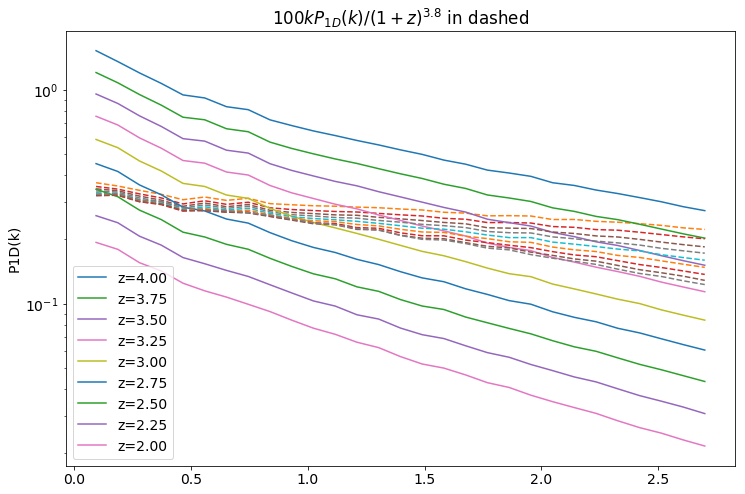

In [5]:
## What we were emulating before: P1D(k)
plt.figure(figsize=(12,8))
plt.title(r"$100kP_{1D}(k)/(1+z)^{3.8}$ in dashed")
for item in truth.data:
    plt.plot(item["k_Mpc"][1:30],item["p1d_Mpc"][1:30],label="z=%.2f" % item["z"])
    #plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*item["k_Mpc"][1:30]*item["p1d_Mpc"][1:30]),linestyle="dashed")
    plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*((1+item["k_Mpc"][1:30]))*item["p1d_Mpc"][1:30]),linestyle="dashed")
plt.yscale("log")
plt.legend()
plt.ylabel("P1D(k)")
plt.show()

In [6]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


In [7]:
arxiv_tau=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=False,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [8]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


In [9]:
emu_red=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var=True)

Training GP on 261 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [10]:
emu_tau=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv_tau,
                                reduce_var=True)

Training GP on 783 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [11]:
#emu_tau.load_hyperparams(emu_red.gp.param_array,emu_red.paramLimits)

In [12]:
mean=np.empty(len(emu_red.training_k_bins)-1)
std=np.empty(len(emu_red.training_k_bins)-1)
mean_red=np.empty(len(emu_red.training_k_bins)-1)
std_red=np.empty(len(emu_red.training_k_bins)-1)
for aa in range(1,len(emu_red.training_k_bins)):
    mean[aa-1]=np.mean(emu.normspectra[:,aa])
    std[aa-1]=np.std(emu.normspectra[:,aa])
    mean_red[aa-1]=np.mean(emu_red.normspectra[:,aa])
    std_red[aa-1]=np.std(emu_red.normspectra[:,aa])

Text(0, 0.5, 'Variance in training function')

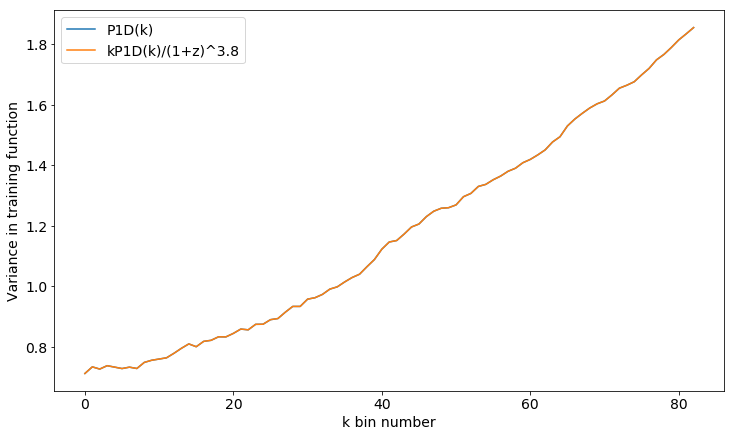

In [13]:
plt.figure(figsize=[12,7])
plt.plot(std,label="P1D(k)")
plt.plot(std_red,label="kP1D(k)/(1+z)^3.8")
plt.xlabel("k bin number")
plt.legend()
plt.ylabel("Variance in training function")

[-4.95137265e-11 -1.13054011e-10 -1.62463376e-11  1.75099935e-11
 -1.19846688e-10  6.97997216e-11  1.75666370e-10  1.02284070e-10
 -8.69486705e-11 -4.51925164e-11  4.25652846e-11  3.24906768e-12
  2.08129070e-11  1.47433177e-11  1.88478122e-11  3.80043774e-11
  3.48076568e-11  2.76354495e-11  2.44675946e-11  5.66939828e-11
  4.39649428e-11  2.09090523e-11 -2.38666864e-11  6.67718658e-11
 -1.49250057e-11  7.86417598e-11  1.92506011e-11  2.69748113e-11
  1.26648692e-12  3.24858473e-11 -2.16818785e-11 -2.95702907e-11
 -1.70212733e-11  2.93890190e-11 -3.68094444e-12 -1.59051661e-11
  4.58635907e-12 -3.97348821e-13 -1.09278697e-11  5.17764998e-11
  5.99018057e-12 -1.37560241e-11 -1.05833120e-11  1.11216591e-11
  1.06611941e-12 -5.03430631e-13  1.15273902e-11 -6.35597130e-12
  5.17630383e-12 -9.06316688e-12  8.91595131e-12 -2.11861639e-11
  1.46380269e-11 -1.53257684e-11 -3.23786831e-12  2.49575360e-11
 -1.71766074e-11 -1.40006062e-11 -1.07841513e-12 -1.03089759e-12
 -1.66623659e-12  1.03572

Text(0.5, 132.40000000000015, 'k 1/Mpc')

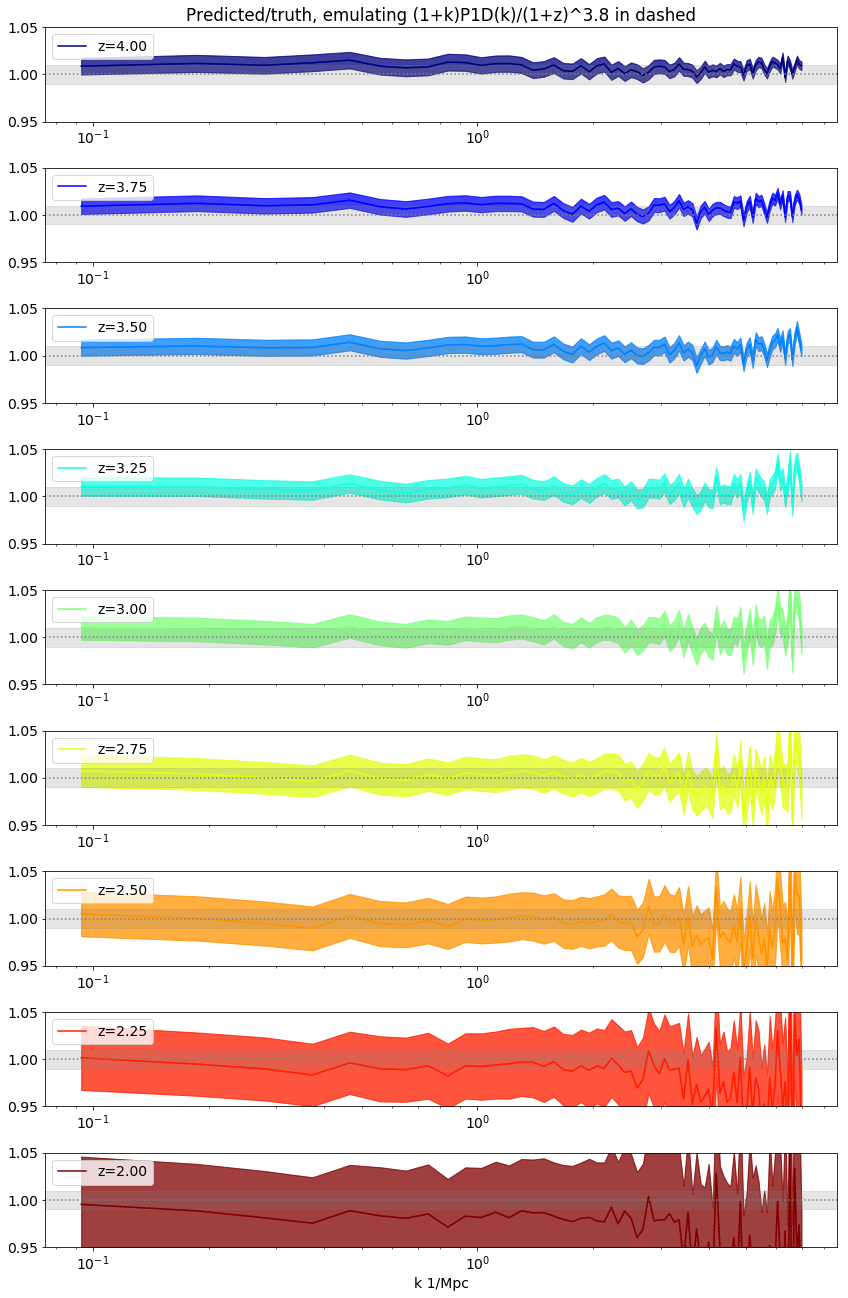

In [26]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_red.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred,color=col,label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau,color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau/item["p1d_Mpc"][2:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")
#plt.savefig("reduced_var_k.pdf")

Text(0.5, 132.40000000000015, 'k 1/Mpc')

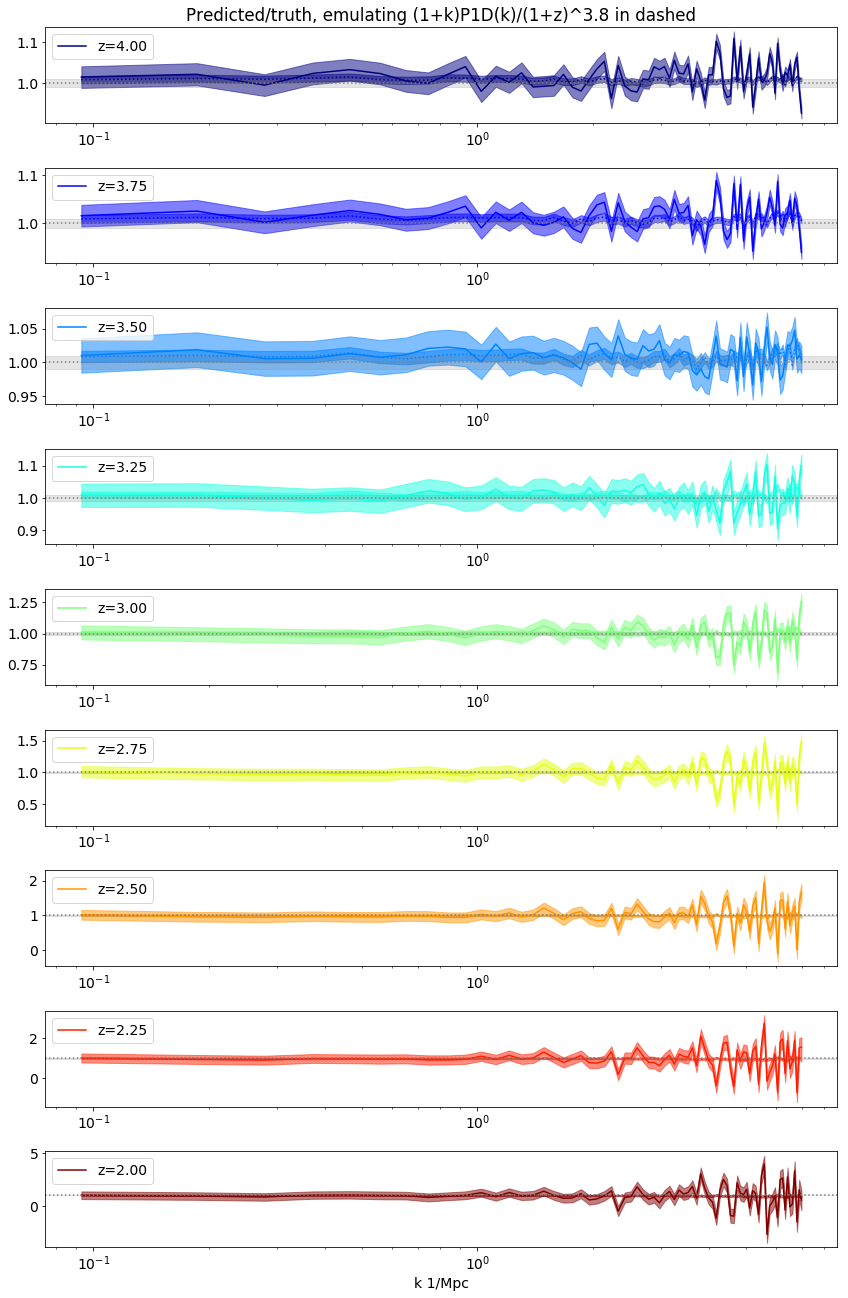

In [15]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu_tau.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_red.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])#
    #print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred,color=col,label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau,color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau/item["p1d_Mpc"][2:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    #plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")
#plt.savefig("reduced_var_k.pdf")

In [16]:
emu.gp.param_array

array([2.50476861e+01, 2.82171850e+01, 1.07176400e+00, 6.54648608e-06])

In [17]:
emu_red.gp.param_array

array([2.50476797e+01, 2.82171836e+01, 1.07176399e+00, 6.54648576e-06])

In [18]:
emu_tau.gp.param_array

array([1.77647542e+01, 4.27830246e+00, 4.39842057e-01, 6.14254571e-17])

In [19]:
emu_tau.paramLimits

array([[ 0.26701081,  0.88314482],
       [ 0.08785083,  0.15489765],
       [ 1.12802305,  1.82432761],
       [ 7.90431314, 15.63489649],
       [ 0.16315329,  0.78107033],
       [-2.34833374, -2.25166652]])

In [20]:
emu_red.paramLimits

array([[ 0.28531175,  0.87511504],
       [ 0.08785083,  0.15489765],
       [ 1.12802305,  1.82432761],
       [ 7.90431314, 15.63489649],
       [ 0.16315329,  0.78107033],
       [-2.34833374, -2.25166652]])

In [21]:
mean=np.empty(len(emu_red.training_k_bins)-1)
std=np.empty(len(emu_red.training_k_bins)-1)
mean_red=np.empty(len(emu_red.training_k_bins)-1)
std_red=np.empty(len(emu_red.training_k_bins)-1)
for aa in range(1,len(emu_red.training_k_bins)):
    mean[aa-1]=np.mean(emu.normspectra[:,aa])
    std[aa-1]=np.std(emu.normspectra[:,aa])
    mean_red[aa-1]=np.mean(emu_red.normspectra[:,aa])
    std_red[aa-1]=np.std(emu_red.normspectra[:,aa])

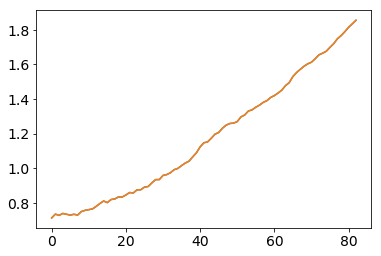

In [22]:
plt.plot(std_red)
plt.plot(std)

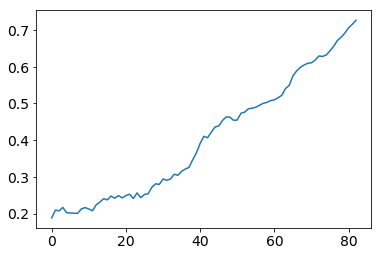

In [23]:
plt.plot(mean)

In [24]:
emu_red.scalefactors

array([0.61988621, 0.61435464, 0.57130384, 0.55044993, 0.51357021,
       0.53396565, 0.51862108, 0.52744951, 0.4991211 , 0.4839511 ,
       0.47360887, 0.47269916, 0.46829897, 0.45530713, 0.44338288,
       0.43341933, 0.42600568, 0.41477758, 0.40479643, 0.39818125,
       0.39676004, 0.38081126, 0.37465384, 0.37098497, 0.35919993,
       0.3554515 , 0.34427444, 0.33425451, 0.32200111, 0.31357342,
       0.30470758, 0.29399752, 0.28865024, 0.28037818, 0.26926338,
       0.26420307, 0.25466542, 0.24782909, 0.23980453, 0.22943324,
       0.2202918 , 0.21095566, 0.20212688, 0.19719245, 0.19008151,
       0.18273024, 0.17740888, 0.17059279, 0.16484715, 0.16007091,
       0.15650427, 0.15183976, 0.14557452, 0.14104525, 0.13616589,
       0.13236329, 0.12833021, 0.12437276, 0.12027263, 0.11662923,
       0.11328154, 0.10953193, 0.10587273, 0.1024978 , 0.0982492 ,
       0.0947866 , 0.09043799, 0.08717725, 0.08419799, 0.08151718,
       0.07890786, 0.07666474, 0.07413321, 0.07157409, 0.06956

In [25]:
old_red=array([3.23445903e-02, 2.56384752e+00, 9.69125651e-01, 6.03394572e-06])

NameError: name 'array' is not defined